# Imports

In [ ]:
!pip install -q matplotlib torch FrEIA ipympl


[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


# Model building and Data generation

In [22]:
import pickle
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import time
from tqdm import tqdm
import FrEIA.framework as Ff
import FrEIA.modules as Fm
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device", device)

def subnet_fc(dims_in, dims_out):
    return nn.Sequential(
        nn.Linear(dims_in, 256), nn.LeakyReLU(0.1),
        nn.Linear(256, 256), nn.LeakyReLU(0.1),
        nn.Linear(256, dims_out)
    )

def INN(num_joints=4):
    nodes = [Ff.InputNode(num_joints, name='input')]
    for k in range(10):
        nodes.append(Ff.Node(nodes[-1],
                             Fm.PermuteRandom,
                             {'seed': k},
                             name=f'perm_{k}'))
        nodes.append(Ff.Node(nodes[-1],
                             Fm.GLOWCouplingBlock,
                             {'subnet_constructor': subnet_fc, 'clamp': 1.9},
                             name=f'glow_{k}'))
    nodes.append(Ff.OutputNode(nodes[-1], name='output'))
    return Ff.GraphINN(nodes)

def forward_kinematics(thetas: torch.Tensor) -> torch.Tensor:
    lengths = torch.tensor([0.5, 0.5, 1.0], device=thetas.device).float()
    batch_size = thetas.shape[0]
    num_joints = thetas.shape[1]
    num_segments = lengths.shape[0]
    angle = torch.zeros(batch_size, device=thetas.device)
    p_current = torch.stack([torch.zeros(batch_size, device=thetas.device), thetas[:, 0]], dim=1)
    for joint_idx in range(num_segments):
        angle = angle + thetas[:, joint_idx + 1]
        length_val = lengths[joint_idx]
        delta_x = length_val * torch.cos(angle)
        delta_y = length_val * torch.sin(angle)
        p_current[:, 0] = p_current[:, 0] + delta_x
        p_current[:, 1] = p_current[:, 1] + delta_y
    return p_current

def train_set(n_samples=1000):
    sigma1 = 0.25
    sigma_others = 0.5
    x1 = torch.randn(n_samples) * sigma1
    x2 = torch.randn(n_samples) * sigma_others
    x3 = torch.randn(n_samples) * sigma_others
    x4 = torch.randn(n_samples) * sigma_others

    x = torch.stack([x1, x2, x3, x4], dim=1)
    y = forward_kinematics(x.to(device))

    return x, y.detach()

Using device cuda


# Training part

In [23]:
def train_model(model, x_train, y_train, n_epochs=10, batch_size=512, lr=1e-4, weight_fk=10.0, weight_latent=1.0, weight_rev=5.0):
    print("Starting INN training...")
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    mse_loss = nn.MSELoss()
    num_joints = x_train.shape[1]
    pos_dim = y_train.shape[1]
    latent_dim = num_joints - pos_dim
    start_time = time.time()

    x_train = x_train.to(device)
    y_train = y_train.to(device)
    for epoch in range(n_epochs):
        if epoch % 5 == 0:
            print(f'Current epoch {epoch}/{n_epochs-1}')
        model.train()
        epoch_loss_f = 0.0
        epoch_loss_z = 0.0
        epoch_loss_rev = 0.0
        epoch_loss_total = 0.0

        n_batches = max(1, len(x_train) // batch_size)
        batch_iterator = tqdm(range(n_batches), desc=f"Epoch {epoch}")

        for i in batch_iterator:
            optimizer.zero_grad()
            start = i * batch_size
            end = min(len(x_train), (i + 1) * batch_size)
            x_batch = x_train[start:end]
            y_batch_gt = y_train[start:end]
            current_batch_size = x_batch.shape[0]

            out_inn_tensor, _ = model(x_batch)
            y_pred = out_inn_tensor[:, :pos_dim]
            z_pred = out_inn_tensor[:, pos_dim:]

            loss_f = mse_loss(y_pred, y_batch_gt)
            loss_z = torch.mean(z_pred ** 2) / 2.0

            z_rev_sample = torch.randn(current_batch_size, latent_dim, device=device)
            rev_input = torch.cat((y_batch_gt, z_rev_sample), dim=1)
            x_rev_pred_tensor, _ = model(rev_input, rev=True)
            y_rev_pred = forward_kinematics(x_rev_pred_tensor)
            loss_rev = mse_loss(y_rev_pred, y_batch_gt)

            total_loss = weight_fk * loss_f + weight_latent * loss_z + weight_rev * loss_rev
            total_loss.backward()
            optimizer.step()

            epoch_loss_f += loss_f.item()
            epoch_loss_z += loss_z.item()
            epoch_loss_rev += loss_rev.item()
            epoch_loss_total += total_loss.item()

            batch_iterator.set_postfix({
                'Loss': f'{total_loss.item():.4f}',
                'Fk': f'{loss_f.item():.4f}',
                'Z': f'{loss_z.item():.4f}',
                'Rev': f'{loss_rev.item():.4f}'
            })

        avg_epoch_loss = epoch_loss_total / n_batches
        avg_epoch_loss_f = epoch_loss_f / n_batches
        avg_epoch_loss_z = epoch_loss_z / n_batches
        avg_epoch_loss_rev = epoch_loss_rev / n_batches
        elapsed_time = time.time() - start_time
        if epoch % 5 == 0:
            print(f"\nEpoch {epoch+1}/{n_epochs} - Time: {elapsed_time:.1f}s "  f"- Train Loss: {avg_epoch_loss:.4f} (F:{avg_epoch_loss_f:.4f}, Z:{avg_epoch_loss_z:.4f}, R:{avg_epoch_loss_rev:.4f})")

    print("Training finished.")

# Model loading for evaluation

In [24]:
model = INN()
model.to(device) # Move the model to the appropriate device
x_train, y_train = train_set(10**6)
x_train, y_train = x_train.to(device), y_train.to(device)
train_model(model, x_train, y_train, n_epochs=60, batch_size=8192, lr=1e-4, weight_fk=10.0, weight_latent=1.0, weight_rev=5.0)
# save model
torch.save(model.state_dict(), 'robot_arm.pth')

# load model for testing
model = INN()
model.load_state_dict(torch.load('robot_arm.pth'))
model.to(device) # Move the loaded model to the appropriate device
model.eval()

Starting INN training...
Current epoch 0/59


Epoch 0: 100%|██████████| 122/122 [00:06<00:00, 18.47it/s, Loss=0.4189, Fk=0.0083, Z=0.1721, Rev=0.0327]



Epoch 1/60 - Time: 6.6s - Train Loss: 2.1360 (F:0.0957, Z:0.2917, R:0.1775)


Epoch 4: 100%|██████████| 122/122 [00:06<00:00, 19.77it/s, Loss=0.0913, Fk=0.0016, Z=0.0380, Rev=0.0074]


Current epoch 5/59


Epoch 5: 100%|██████████| 122/122 [00:06<00:00, 20.05it/s, Loss=0.1863, Fk=0.0038, Z=0.0793, Rev=0.0139]



Epoch 6/60 - Time: 36.9s - Train Loss: 0.1341 (F:0.0025, Z:0.0445, R:0.0129)


Epoch 9: 100%|██████████| 122/122 [00:06<00:00, 19.32it/s, Loss=0.0516, Fk=0.0007, Z=0.0234, Rev=0.0043]


Current epoch 10/59


Epoch 10: 100%|██████████| 122/122 [00:05<00:00, 21.21it/s, Loss=0.0455, Fk=0.0006, Z=0.0208, Rev=0.0038]



Epoch 11/60 - Time: 68.4s - Train Loss: 0.0423 (F:0.0006, Z:0.0160, R:0.0040)


Epoch 14: 100%|██████████| 122/122 [00:06<00:00, 17.65it/s, Loss=0.0331, Fk=0.0004, Z=0.0146, Rev=0.0029]


Current epoch 15/59


Epoch 15: 100%|██████████| 122/122 [00:06<00:00, 18.25it/s, Loss=0.0301, Fk=0.0004, Z=0.0131, Rev=0.0027]



Epoch 16/60 - Time: 100.3s - Train Loss: 0.0263 (F:0.0004, Z:0.0089, R:0.0027)


Epoch 19: 100%|██████████| 122/122 [00:06<00:00, 18.92it/s, Loss=0.0213, Fk=0.0003, Z=0.0086, Rev=0.0020]


Current epoch 20/59


Epoch 20: 100%|██████████| 122/122 [00:06<00:00, 20.21it/s, Loss=0.0247, Fk=0.0005, Z=0.0082, Rev=0.0023]



Epoch 21/60 - Time: 130.7s - Train Loss: 0.0201 (F:0.0003, Z:0.0063, R:0.0021)


Epoch 24: 100%|██████████| 122/122 [00:06<00:00, 18.98it/s, Loss=0.0227, Fk=0.0004, Z=0.0070, Rev=0.0023]


Current epoch 25/59


Epoch 25: 100%|██████████| 122/122 [00:05<00:00, 20.90it/s, Loss=0.0237, Fk=0.0005, Z=0.0066, Rev=0.0024]



Epoch 26/60 - Time: 162.3s - Train Loss: 0.0160 (F:0.0003, Z:0.0048, R:0.0017)


Epoch 29: 100%|██████████| 122/122 [00:05<00:00, 20.53it/s, Loss=0.0137, Fk=0.0002, Z=0.0058, Rev=0.0012]


Current epoch 30/59


Epoch 30: 100%|██████████| 122/122 [00:06<00:00, 19.58it/s, Loss=0.0169, Fk=0.0003, Z=0.0056, Rev=0.0016]



Epoch 31/60 - Time: 192.5s - Train Loss: 0.0134 (F:0.0002, Z:0.0039, R:0.0014)


Epoch 34: 100%|██████████| 122/122 [00:06<00:00, 20.07it/s, Loss=0.0130, Fk=0.0002, Z=0.0052, Rev=0.0012]


Current epoch 35/59


Epoch 35: 100%|██████████| 122/122 [00:05<00:00, 20.65it/s, Loss=0.0118, Fk=0.0002, Z=0.0046, Rev=0.0011]



Epoch 36/60 - Time: 224.1s - Train Loss: 0.0112 (F:0.0002, Z:0.0033, R:0.0012)


Epoch 39: 100%|██████████| 122/122 [00:06<00:00, 20.30it/s, Loss=0.0168, Fk=0.0005, Z=0.0038, Rev=0.0017]


Current epoch 40/59


Epoch 40: 100%|██████████| 122/122 [00:06<00:00, 19.54it/s, Loss=0.0104, Fk=0.0002, Z=0.0037, Rev=0.0010]



Epoch 41/60 - Time: 255.0s - Train Loss: 0.0102 (F:0.0002, Z:0.0027, R:0.0011)


Epoch 44: 100%|██████████| 122/122 [00:05<00:00, 20.52it/s, Loss=0.0093, Fk=0.0001, Z=0.0034, Rev=0.0009]


Current epoch 45/59


Epoch 45: 100%|██████████| 122/122 [00:06<00:00, 19.77it/s, Loss=0.0124, Fk=0.0003, Z=0.0033, Rev=0.0012]



Epoch 46/60 - Time: 285.4s - Train Loss: 0.0089 (F:0.0002, Z:0.0024, R:0.0010)


Epoch 49: 100%|██████████| 122/122 [00:05<00:00, 20.98it/s, Loss=0.0115, Fk=0.0003, Z=0.0027, Rev=0.0011]


Current epoch 50/59


Epoch 50: 100%|██████████| 122/122 [00:06<00:00, 18.11it/s, Loss=0.0080, Fk=0.0001, Z=0.0027, Rev=0.0008]



Epoch 51/60 - Time: 316.9s - Train Loss: 0.0082 (F:0.0002, Z:0.0021, R:0.0009)


Epoch 54: 100%|██████████| 122/122 [00:06<00:00, 17.46it/s, Loss=0.0072, Fk=0.0001, Z=0.0026, Rev=0.0007]


Current epoch 55/59


Epoch 55: 100%|██████████| 122/122 [00:06<00:00, 19.71it/s, Loss=0.0064, Fk=0.0001, Z=0.0025, Rev=0.0006]



Epoch 56/60 - Time: 349.5s - Train Loss: 0.0074 (F:0.0002, Z:0.0019, R:0.0008)


Epoch 59: 100%|██████████| 122/122 [00:06<00:00, 20.10it/s, Loss=0.0117, Fk=0.0003, Z=0.0022, Rev=0.0013]


Training finished.


GraphINN(
  (module_list): ModuleList(
    (0): PermuteRandom()
    (1): GLOWCouplingBlock(
      (subnet1): Sequential(
        (0): Linear(in_features=2, out_features=256, bias=True)
        (1): LeakyReLU(negative_slope=0.1)
        (2): Linear(in_features=256, out_features=256, bias=True)
        (3): LeakyReLU(negative_slope=0.1)
        (4): Linear(in_features=256, out_features=4, bias=True)
      )
      (subnet2): Sequential(
        (0): Linear(in_features=2, out_features=256, bias=True)
        (1): LeakyReLU(negative_slope=0.1)
        (2): Linear(in_features=256, out_features=256, bias=True)
        (3): LeakyReLU(negative_slope=0.1)
        (4): Linear(in_features=256, out_features=4, bias=True)
      )
    )
    (2): PermuteRandom()
    (3): GLOWCouplingBlock(
      (subnet1): Sequential(
        (0): Linear(in_features=2, out_features=256, bias=True)
        (1): LeakyReLU(negative_slope=0.1)
        (2): Linear(in_features=256, out_features=256, bias=True)
        (3): 

# Infer x function : Configuration to end edductor coordinates

In [25]:
def infer_x(model , x_test):
  with torch.no_grad():
    x_test = x_test.to(device)
    out_inn_tensor, _ = model(x_test)
    y_pred = out_inn_tensor[:, :2]
    z_pred = out_inn_tensor[:, 2:]
    return y_pred, z_pred

# Example usage

x_test = torch.randn(1, 4)
y_pred, z_pred = infer_x(model, x_test)
y_actual = forward_kinematics(x_test)
print("Input:", x_test)
print("Predicted y:", y_pred)
print("Actual y:", y_actual)

Input: tensor([[ 0.3820,  0.9666, -0.2774,  0.1633]])
Predicted y: tensor([[1.3374, 1.8707]], device='cuda:0')
Actual y: tensor([[1.3281, 1.8643]])


# Infer y function : end edductor coordinates to possible configurations

Model loaded successfully.
Generated 1000 configurations for target [[1.0, 0.0]]
Mean Euclidean distance of predicted EEs to target: 0.1840


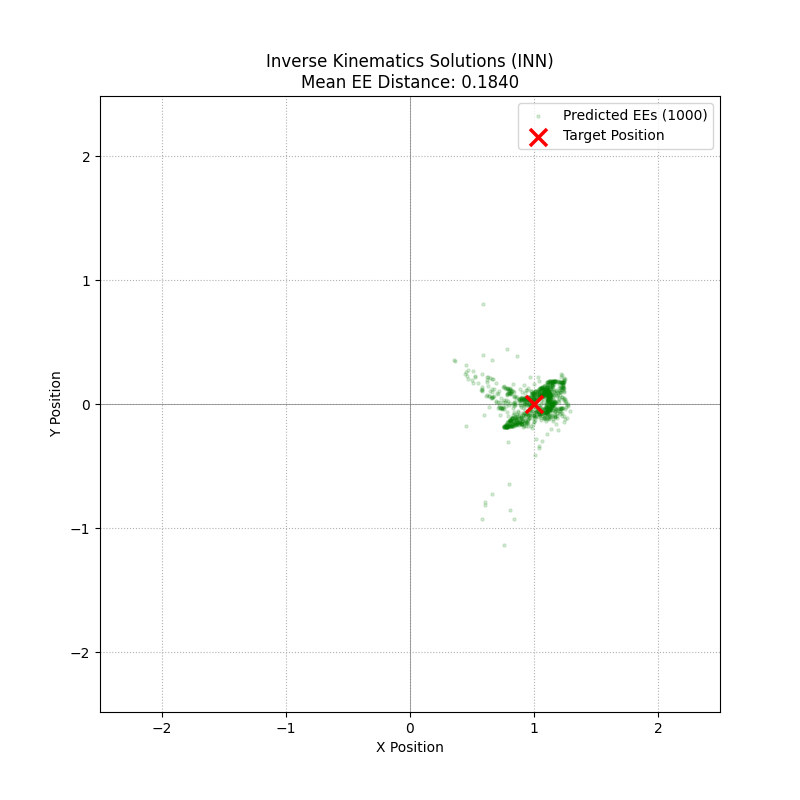

In [34]:
def infer_y(model, y_target, n_samples=100):
    model.eval()
    device = next(model.parameters()).device

    y_target = torch.tensor(y_target, dtype=torch.float32).to(device)
    if y_target.dim() == 1:
        y_target = y_target.unsqueeze(0)

    batch_size = y_target.shape[0]
    pos_dim = y_target.shape[1]
    x_dim = model.dims_in[0][0] if model.dims_in else 4
    latent_dim = x_dim - pos_dim

    if latent_dim <= 0:
        print(f"Warning: Latent dimension ({latent_dim}) is not positive. "
              f"Model input dim ({x_dim}), y_target dim ({pos_dim}). Sampling multiple solutions might not be meaningful.")
        if n_samples > 1:
            n_samples = 1

    z_samples = torch.randn(batch_size, n_samples, latent_dim, device=device)
    y_target_expanded = y_target.unsqueeze(1).expand(-1, n_samples, -1)
    rev_input = torch.cat((y_target_expanded, z_samples), dim=2)
    total_samples = batch_size * n_samples
    rev_input_flat = rev_input.view(total_samples, x_dim)

    with torch.no_grad():
        x_pred_flat, _ = model(rev_input_flat, rev=True)

    x_pred = x_pred_flat.view(batch_size, n_samples, x_dim)

    if batch_size == 1:
        x_pred = x_pred.squeeze(0)

    return x_pred

target_pos = [[1.0, 0.0]]

model = INN(num_joints=4)
try:
    model.load_state_dict(torch.load('robot_arm.pth', map_location=device))
    model.to(device)
    model.eval()
    print("Model loaded successfully.")

    num_solutions = 1000
    thetas_pred = infer_y(model, target_pos, n_samples=num_solutions)

    print(f"Generated {thetas_pred.shape[0]} configurations for target {target_pos}")

    if thetas_pred.shape[0] > 0:
        predicted_positions = forward_kinematics(thetas_pred.to(device))

        plt.figure(figsize=(8, 8))
        points_np = predicted_positions.detach().cpu().numpy()
        plt.scatter(points_np[:, 0], points_np[:, 1], alpha=0.15, s=5, label=f'Predicted EEs ({num_solutions})', c='green', zorder=5)

        target_pos_np = np.array(target_pos)
        plt.scatter(target_pos_np[:, 0], target_pos_np[:, 1], marker='x', color='red', s=150, linewidth=2.5, label='Target Position', zorder=10)

        target_tensor = torch.tensor(target_pos, dtype=torch.float32).to(device)
        if target_tensor.shape[0] != predicted_positions.shape[0]:
            target_tensor = target_tensor.repeat_interleave(num_solutions, dim=0)

        mean_dist = torch.sqrt(((predicted_positions - target_tensor) ** 2).sum(dim=1)).mean()
        print(f"Mean Euclidean distance of predicted EEs to target: {mean_dist.item():.4f}")

        plt.title(f"Inverse Kinematics Solutions (INN)\nMean EE Distance: {mean_dist.item():.4f}")
        plt.xlabel("X Position")
        plt.ylabel("Y Position")
        plt.legend()
        plt.axis('equal')
        plt.grid(True, linestyle=':')
        plt.axhline(0, color='grey', lw=0.5)
        plt.axvline(0, color='grey', lw=0.5)
        max_reach = 0.5 + 0.5 + 1.0 + 0.5
        plt.xlim(-max_reach, max_reach)
        plt.ylim(-max_reach, max_reach)

        plt.show()
    else:
        print("No solutions generated.")
except Exception as e:
    print(f"An error occurred during inference or plotting: {e}")


# Simulation
The following cell does the simulations of infer_y, you give the coordinate and it tells use the end edductor coordinates generated by possible configurations generated by infer_y with target point as input

Model loaded successfully.


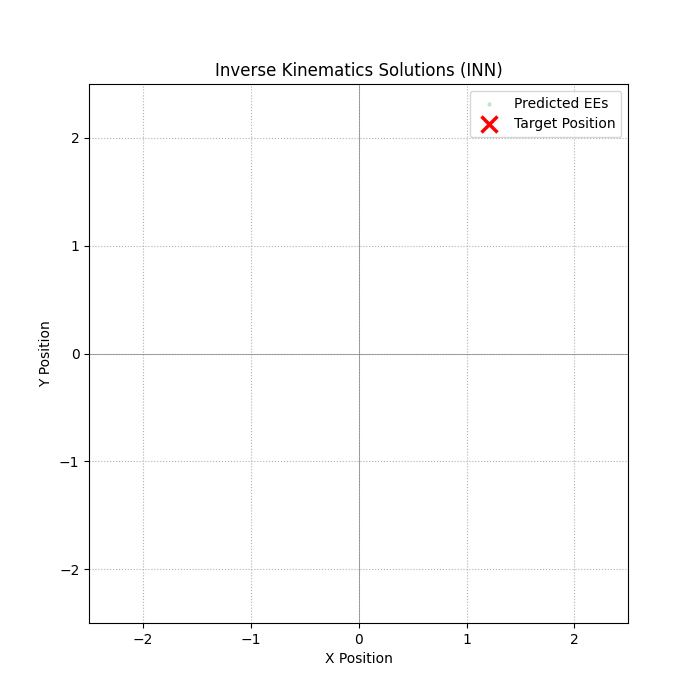

In [45]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# --- Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model
model = INN(num_joints=4)
model.load_state_dict(torch.load('robot_arm.pth', map_location=device))
model.to(device)
model.eval()
print("Model loaded successfully.")

num_solutions = 1000
max_reach = 0.5 + 0.5 + 1.0 + 0.5

# --- Create the initial plot ---
%matplotlib widget
fig, ax = plt.subplots(figsize=(7, 7))
sc = ax.scatter([], [], alpha=0.15, s=5, c='green', zorder=5, label='Predicted EEs')
target_marker, = ax.plot([], [], 'rx', markersize=12, mew=2.5, label='Target Position', zorder=10)

ax.set_xlim(-max_reach, max_reach)
ax.set_ylim(-max_reach, max_reach)
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.set_title("Inverse Kinematics Solutions (INN)")
ax.grid(True, linestyle=':')
ax.axhline(0, color='grey', lw=0.5)
ax.axvline(0, color='grey', lw=0.5)
ax.legend()
ax.set_aspect('equal')

# --- Define widgets ---
x_input = widgets.FloatText(value=1.0, description='X:', step=0.1)
y_input = widgets.FloatText(value=0.0, description='Y:', step=0.1)
run_button = widgets.Button(description='Generate IK')
display(widgets.HBox([x_input, y_input, run_button]))

# --- Callback function ---
def on_click(_):
    x = x_input.value
    y = y_input.value
    target_pos = [[x, y]]
    print(f"\nGenerating IK for target: ({x:.2f}, {y:.2f})")

    try:
        thetas_pred = infer_y(model, target_pos, n_samples=num_solutions)
        if thetas_pred.shape[0] == 0:
            print("No solutions generated.")
            return

        predicted_positions = forward_kinematics(thetas_pred.to(device))
        points_np = predicted_positions.detach().cpu().numpy()

        # Compute mean distance
        target_tensor = torch.tensor(target_pos, dtype=torch.float32).to(device)
        target_tensor = target_tensor.repeat_interleave(num_solutions, dim=0)
        mean_dist = torch.sqrt(((predicted_positions - target_tensor) ** 2).sum(dim=1)).mean()
        print(f"Mean EE distance to target: {mean_dist.item():.4f}")

        # Update the plot

        # Mark target point as red point
        target_pos_np = np.array(target_pos)
        target_marker.set_data(target_pos_np[:, 0], target_pos_np[:, 1])
        target_marker.set_visible(True)

        sc.set_offsets(points_np)
        target_marker.set_data(x, y)
    
        ax.set_title(f"IK to ({x:.2f}, {y:.2f}) | Mean Dist: {mean_dist.item():.4f}")
        fig.canvas.draw()

    except Exception as e:
        print(f"Error: {e}")

# --- Hook up the button ---
run_button.on_click(on_click)
